In [1]:
import os, sys, math, json, random, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa, soundfile as sf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import roc_auc_score, roc_curve

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [2]:
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Paths
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
CACHE_DIR = PROJECT_ROOT / "outputs" / "cache_cnn04"
OUT_DIR = PROJECT_ROOT / "outputs"
for p in [CACHE_DIR, OUT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

Device: cuda


In [3]:
# Experiment config
MACHINE = "fan"        # choose: fan, pump, slider, valve, toycar, toyconveyor
TARGET_FPR = 0.10      # NP threshold target false positive rate

# Audio and features
SR = 16000
N_FFT = 1024
HOP = 512
N_MELS = 128

# Patch slicing for CNN input
PATCH_T = 64           # time frames per patch
PATCH_STRIDE = 32      # stride between patches

# Training
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50
VAL_SPLIT = 0.1
PATIENCE = 8

# Optional labels CSV for AUC if you have it
LABELS_CSV = None

In [4]:
def list_wavs(machine: str):
    """
    List train and test wav files for a machine.
    Train contains only normal sounds. Test is mixed.
    """
    train = sorted((DATA_DIR / machine / "train").glob("*.wav"))
    test  = sorted((DATA_DIR / machine / "test").glob("*.wav"))
    return train, test

train_paths, test_paths = list_wavs(MACHINE)

print(f"Machine: {MACHINE}")
print(f"Train files: {len(train_paths)}")
print(f"Test files:  {len(test_paths)}")
if train_paths:
    print("Example train:", train_paths[0].name)
if test_paths:
    print("Example test: ", test_paths[0].name)

assert len(train_paths) > 0 and len(test_paths) > 0, "Missing audio files. Check DATA_DIR."

Machine: fan
Train files: 3675
Test files:  1875
Example train: normal_id_00_00000000.wav
Example test:  anomaly_id_00_00000000.wav


In [5]:
def wav_to_logmel(path: Path, sr=SR, n_fft=N_FFT, hop=HOP, n_mels=N_MELS) -> np.ndarray:
    """
    Load mono audio. Make a log-Mel spectrogram.
    Output shape: [n_mels, T]. dtype float32.
    We later slice this into patches for the CNN.
    """
    y, sr0 = librosa.load(path, sr=None, mono=True)
    if sr0 != sr:
        y = librosa.resample(y, orig_sr=sr0, target_sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def extract_patches(mel_db: np.ndarray, win_t=PATCH_T, stride=PATCH_STRIDE) -> np.ndarray:
    """
    Cut [M, T] into overlapping patches of shape [1, M, win_t].
    Returns [N, 1, M, win_t].
    Patch size and stride control how many examples you get.
    """
    M, T = mel_db.shape
    if T < win_t:
        pad = np.tile(mel_db[:, -1:], (1, win_t - T))
        mel_db = np.concatenate([mel_db, pad], axis=1)
        T = mel_db.shape[1]
    patches = []
    for start in range(0, T - win_t + 1, stride):
        patch = mel_db[:, start:start+win_t]
        patches.append(patch[None, :, :])  # add channel dim
    return np.stack(patches, axis=0).astype(np.float32)

def cache_mel(path: Path) -> Path:
    """
    Cache the Mel spectrogram to speed up repeated runs.
    Saves to .npy and returns its path.
    """
    out = CACHE_DIR / f"{path.stem}_mel.npy"
    if not out.exists():
        mel = wav_to_logmel(path)
        np.save(out, mel)
    return out

# Quick preview to confirm preprocessing works
prev_mel = np.load(cache_mel(train_paths[0]))
print("Preview Mel shape:", prev_mel.shape)
print("Preview patches shape:", extract_patches(prev_mel).shape)

Preview Mel shape: (128, 313)
Preview patches shape: (8, 1, 128, 64)


In [6]:
class CNNPatchesDataset(Dataset):
    """
    CNN patches dataset for an autoencoder.

    Train:
      - normal-only patches
      - estimates mean/std for normalization

    Test:
      - mixed patches from test files
      - uses training mean/std (set_norm)
    """
    def __init__(self, paths, train=True):
        self.paths = list(paths)
        self.train = train

        self.index = []               # (file_idx, patch_idx)
        self.file_patch_counts = []   # used to aggregate patch scores back to file scores

        for fi, p in enumerate(tqdm(self.paths, desc="Index patches")):
            mel = np.load(cache_mel(p))
            patches = extract_patches(mel)         # [N,1,M,T]
            self.file_patch_counts.append(len(patches))
            for pi in range(len(patches)):
                self.index.append((fi, pi))

        # Normalization from a subset of train patches
        if self.train:
            k = min(8000, len(self.index))
            sample_idxs = np.random.choice(len(self.index), k, replace=False)
            buf = []
            for idx in sample_idxs:
                fi, pi = self.index[idx]
                mel = np.load(CACHE_DIR / f"{self.paths[fi].stem}_mel.npy")
                buf.append(extract_patches(mel)[pi])   # [1,M,T]
            X = np.concatenate(buf, axis=0)            # [k,1,M,T]
            self.mean = X.mean()
            self.std = X.std() + 1e-6
        else:
            self.mean = None
            self.std = None

    def set_norm(self, mean: float, std: float):
        """Provide mean and std learned from the training dataset."""
        self.mean = float(mean)
        self.std = float(std)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, pi = self.index[idx]
        mel = np.load(CACHE_DIR / f"{self.paths[fi].stem}_mel.npy")
        x = extract_patches(mel)[pi]         # [1,M,T]
        if self.mean is not None:
            x = (x - self.mean) / self.std
        return torch.from_numpy(x), torch.from_numpy(x)

# Build datasets
ds_train_full = CNNPatchesDataset(train_paths, train=True)
val_len = max(1, int(len(ds_train_full) * VAL_SPLIT))
train_len = len(ds_train_full) - val_len
ds_train, ds_val = random_split(ds_train_full, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

ds_test = CNNPatchesDataset(test_paths, train=False)
ds_test.set_norm(ds_train_full.mean, ds_train_full.std)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, drop_last=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train patches:", len(ds_train))
print("Val patches:  ", len(ds_val))
print("Test patches: ", len(ds_test))

Index patches: 100%|██████████| 1875/1875 [00:33<00:00, 55.24it/s] 

Train patches: 26460
Val patches:   2940
Test patches:  15000


In [7]:
class CNNAutoencoder(nn.Module):
    """
    Small 2D CNN autoencoder for Mel patches.
    Input:  [B, 1, 128, PATCH_T]
    Output: [B, 1, 128, PATCH_T]
    """
    def __init__(self, in_ch=1):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),          # [64, T/2]
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),          # [32, T/4]
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1)
        )

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

model = CNNAutoencoder().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()
print("Model params:", sum(p.numel() for p in model.parameters()))

Model params: 33729


In [8]:
def train_epoch(model, loader, opt, loss_fn):
    """
    One training epoch on normal patches.
    Returns average MSE over the dataset.
    """
    model.train()
    total = 0.0
    for x, y in loader:
        x = x.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)
        opt.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, loss_fn):
    """
    One validation epoch on normal patches.
    Returns average MSE.
    """
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE, dtype=torch.float32)
            y = y.to(DEVICE, dtype=torch.float32)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            total += loss.item() * x.size(0)
    return total / len(loader.dataset)

best_val = math.inf
best_state = None
patience_ctr = 0

for epoch in range(1, EPOCHS+1):
    tr = train_epoch(model, dl_train, opt, loss_fn)
    va = eval_epoch(model, dl_val, loss_fn)
    print(f"[{epoch:03d}] train={tr:.6f}  val={va:.6f}")

    if va < best_val - 1e-6:
        best_val = va
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

[001] train=0.111734  val=0.076555
[002] train=0.069965  val=0.062260
[003] train=0.055921  val=0.051968
[004] train=0.049723  val=0.048463
[005] train=0.046589  val=0.045115
[006] train=0.044531  val=0.043514
[007] train=0.042964  val=0.043890
[008] train=0.041787  val=0.040943
[009] train=0.040755  val=0.040156
[010] train=0.039840  val=0.039054
[011] train=0.039019  val=0.038684
[012] train=0.038229  val=0.037477
[013] train=0.037467  val=0.037521
[014] train=0.036826  val=0.036234
[015] train=0.036177  val=0.035817
[016] train=0.035587  val=0.035234
[017] train=0.035063  val=0.034372
[018] train=0.034599  val=0.034016
[019] train=0.034110  val=0.033899
[020] train=0.033711  val=0.034800
[021] train=0.033358  val=0.033495
[022] train=0.032989  val=0.032471
[023] train=0.032661  val=0.032077
[024] train=0.032352  val=0.031782
[025] train=0.032036  val=0.031690
[026] train=0.031759  val=0.031510
[027] train=0.031521  val=0.031149
[028] train=0.031254  val=0.031340
[029] train=0.031033

In [9]:
def patch_mse(model, loader):
    """
    Compute per-patch reconstruction error for all items in a loader.
    Returns a 1D numpy array of errors.
    """
    model.eval()
    errs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE, dtype=torch.float32)
            y = model(x)
            e = F.mse_loss(y, x, reduction="none")
            e = e.view(e.size(0), -1).mean(dim=1)  # reduce over [C,M,T]
            errs.append(e.cpu().numpy())
    return np.concatenate(errs, axis=0)

def np_threshold(normal_scores: np.ndarray, target_fpr: float) -> float:
    """
    Neyman–Pearson selection on validation normals.
    We pick the 1 - target_fpr quantile as threshold.
    """
    return float(np.quantile(normal_scores, 1.0 - target_fpr))

val_scores = patch_mse(model, dl_val)
thr_patch = np_threshold(val_scores, TARGET_FPR)
print("NP threshold (patch-level):", thr_patch)

NP threshold (patch-level): 0.029121236875653267


In [10]:
test_patch_scores = patch_mse(model, dl_test)

# Aggregate to file level
file_scores_mean = []
file_scores_q90  = []  # for brief anomalies you may prefer a high quantile
offset = 0
for count in ds_test.file_patch_counts:
    seg = test_patch_scores[offset:offset+count]
    offset += count
    file_scores_mean.append(float(np.mean(seg)))
    file_scores_q90.append(float(np.quantile(seg, 0.90)))

file_scores_mean = np.array(file_scores_mean)
file_scores_q90  = np.array(file_scores_q90)

# Optional labels for AUC (if you have them)
labels = None
if LABELS_CSV and Path(LABELS_CSV).exists():
    lab = pd.read_csv(LABELS_CSV)
    lab["stem"] = lab["path"].apply(lambda p: Path(p).stem)
    stems = [p.stem for p in test_paths]
    joined = pd.DataFrame({"stem": stems, "score_mean": file_scores_mean, "score_q90": file_scores_q90}) \
              .merge(lab[["stem","label"]], on="stem", how="left")
    if joined["label"].notna().all():
        labels = joined["label"].astype(int).values
        file_scores_mean = joined["score_mean"].values
        file_scores_q90  = joined["score_q90"].values
    else:
        print("Labels CSV found but not all stems matched. Skipping AUC.")

def compute_auc(scores, labels):
    if labels is None:
        return None, None
    auc = roc_auc_score(labels, scores)
    fpr, tpr, thr = roc_curve(labels, scores)
    mask = fpr <= 0.1
    p_auc = np.trapz(tpr[mask], fpr[mask]) / 0.1 if mask.sum() >= 2 else None
    return float(auc), (float(p_auc) if p_auc is not None else None)

auc_mean, pauc_mean = compute_auc(file_scores_mean, labels)
auc_q90,  pauc_q90  = compute_auc(file_scores_q90,  labels)
print("AUC mean:", auc_mean, " pAUC@0.1 mean:", pauc_mean)
print("AUC q90 :", auc_q90,  " pAUC@0.1 q90 :", pauc_q90)

# Save scores
out_csv = OUT_DIR / f"{MACHINE}_cnn04_scores.csv"
pd.DataFrame({
    "path": [str(p) for p in test_paths],
    "score_mean": file_scores_mean,
    "score_q90": file_scores_q90,
    "np_threshold_patch": thr_patch
}).to_csv(out_csv, index=False)
print("Saved:", out_csv)


AUC mean: None  pAUC@0.1 mean: None
AUC q90 : None  pAUC@0.1 q90 : None
Saved: c:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\unsupervised_learning\outputs\fan_cnn04_scores.csv


Lowest score: normal_id_06_00000036.wav


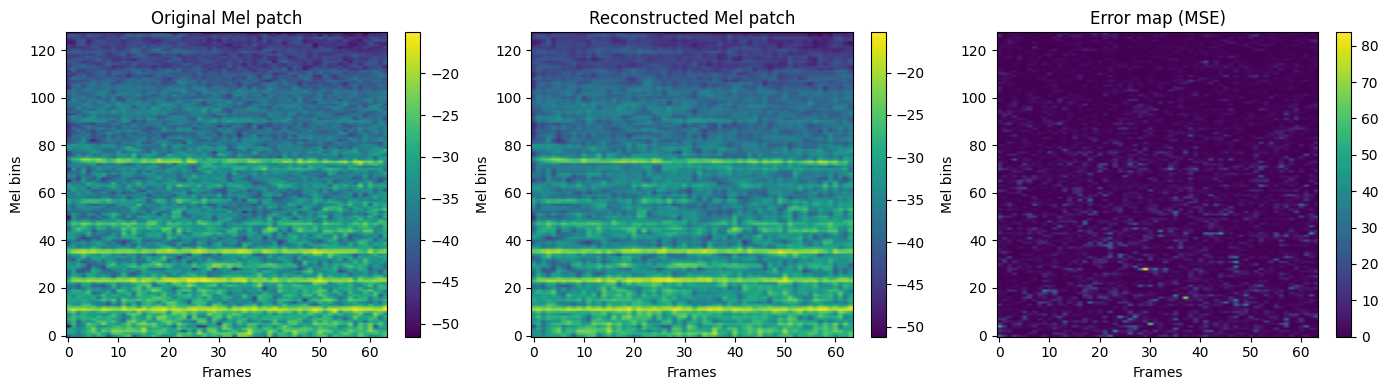

Highest score: normal_id_02_00000056.wav


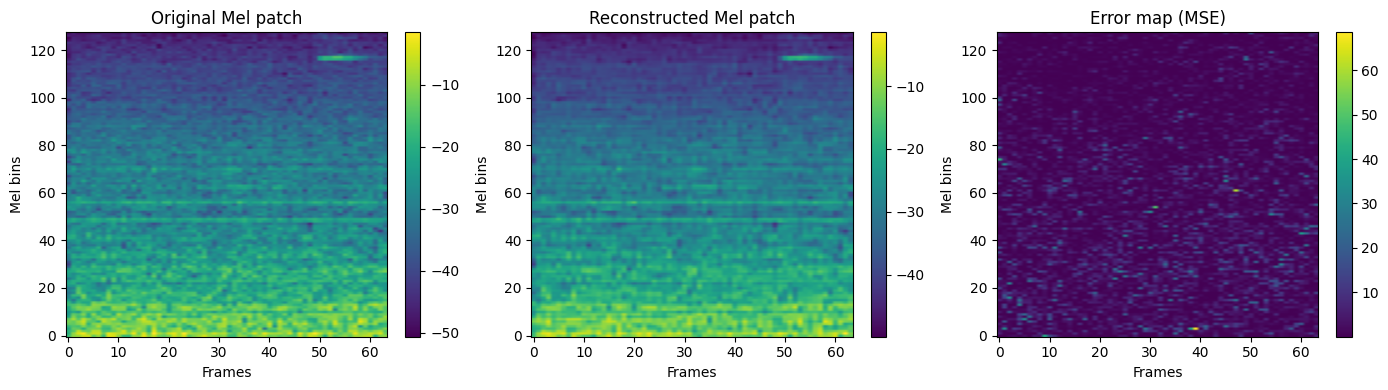

In [11]:
def visualize_triptych(wav_path: Path, model: nn.Module, mean: float, std: float, patch_t=PATCH_T):
    """
    Show Original, Reconstruction, and Error map for the first patch of a file.
    This helps you see if the model captures normal structure.
    """
    model.eval()
    mel = wav_to_logmel(wav_path)                       # [M,T]
    patches = extract_patches(mel, win_t=patch_t)       # [N,1,M,T]
    if len(patches) == 0:
        print("No patches for this file.")
        return
    x = patches[0:1]                                    # [1,1,M,T]
    x_norm = (x - mean) / std

    with torch.no_grad():
        x_t = torch.from_numpy(x_norm).to(DEVICE, dtype=torch.float32)
        y_t = model(x_t)
        y = y_t.detach().cpu().numpy()

    x_rec = y * std + mean
    err = (x_rec - x) ** 2

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    im0 = axs[0].imshow(x[0,0], aspect="auto", origin="lower"); axs[0].set_title("Original Mel patch"); plt.colorbar(im0, ax=axs[0], fraction=0.046)
    im1 = axs[1].imshow(x_rec[0,0], aspect="auto", origin="lower"); axs[1].set_title("Reconstructed Mel patch"); plt.colorbar(im1, ax=axs[1], fraction=0.046)
    im2 = axs[2].imshow(err[0,0], aspect="auto", origin="lower"); axs[2].set_title("Error map (MSE)"); plt.colorbar(im2, ax=axs[2], fraction=0.046)
    for ax in axs: ax.set_xlabel("Frames"); ax.set_ylabel("Mel bins")
    plt.tight_layout(); plt.show()

# Show one low-score and one high-score example
scores_df = pd.DataFrame({"path": [str(p) for p in test_paths], "score_mean": file_scores_mean})
low_path  = Path(scores_df.sort_values("score_mean").iloc[0]["path"])
high_path = Path(scores_df.sort_values("score_mean", ascending=False).iloc[0]["path"])
print("Lowest score:", low_path.name)
visualize_triptych(low_path, model, ds_train_full.mean, ds_train_full.std, patch_t=PATCH_T)
print("Highest score:", high_path.name)
visualize_triptych(high_path, model, ds_train_full.mean, ds_train_full.std, patch_t=PATCH_T)

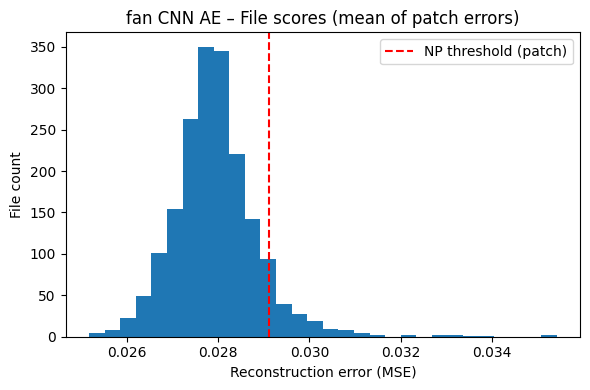

In [12]:
plt.figure(figsize=(6,4))
plt.hist(file_scores_mean, bins=30)
plt.axvline(thr_patch, color="r", ls="--", label="NP threshold (patch)")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("File count")
plt.title(f"{MACHINE} CNN AE – File scores (mean of patch errors)")
plt.legend(); plt.tight_layout(); plt.show()